<a href="https://colab.research.google.com/github/Raagulbharatwaj/BERT/blob/main/Sentence_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Textual Similarity

Semantic Textual Similarity is one of the major focuses of research in NLP tasks. Semantic Textual Similarity involves comparing two sentences semantically and finding the amount of similarity as a numeric measure.

<br>

Perhaps the most famous so far, and the current state-of-the-art in sentence similarity is done by German scientists Nils Reimers and Iryna Gurevych at
Ubiquitous Knowledge Processing Lab (UKP-TUDA), Germany. In this notebook, we will explore how to get sentence representations from SentenceBERT.

<br>

You know the drill - install the Transformers library first!

In [101]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
# One more install - this time for Sentence Transformers

!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [103]:
# Initial imports

from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import tensorflow as tf

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA

from sentence_transformers import SentenceTransformer, util

Here's where the action starts. We have entered in the cell below, the sentences 'I am good' and 'I am well'. We will now use the sentenceBERT model to extract the embeddings of both sentences. Let's take a look.

In [104]:
sentence1 = "I am good"
sentence2 = "I am well"

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embedding1 = model.encode(sentence1)
embedding2 = model.encode(sentence2)
print(embedding1)
print(embedding2)

[-4.44729328e-02 -6.41169325e-02 -1.38996672e-02  5.98502345e-03
 -6.86401129e-02  2.83300702e-04  1.08719945e-01  1.37069300e-02
 -7.01571479e-02 -1.43060843e-02  1.50692351e-02 -6.16868474e-02
 -1.59280393e-02 -7.89568468e-04  7.35849366e-02 -1.48512209e-02
  1.59452222e-02 -4.52054664e-02 -1.02363721e-01 -1.09433578e-02
 -1.37880310e-01  4.54124212e-02  8.25411454e-02  2.70946249e-02
 -7.39210472e-02  2.41403212e-03 -9.94821358e-03  7.76677206e-03
  6.58574775e-02 -3.51392068e-02 -8.45831335e-02  1.89159196e-02
  4.44628373e-02 -2.09030528e-02 -5.26019298e-02  5.50589859e-02
 -3.32135893e-02 -9.28306505e-02  8.88481438e-02  3.54514681e-02
  3.71231399e-02 -2.96136625e-02 -2.88637802e-02 -1.49481613e-02
  7.98430236e-04  5.51729500e-02  4.45638504e-03  1.42977117e-02
  5.29855900e-02 -6.63945153e-02 -6.60493150e-02  2.67059896e-02
 -5.40565588e-02  4.54549976e-02  9.22883675e-02  3.77403498e-02
 -2.00231113e-02 -1.32569717e-02  2.21695192e-02 -4.59340662e-02
  7.94849172e-02 -2.66701

A vector of some incomprehensible numbers are displayed. It is normal and sane not to make any sense of it. Like we did in Gensim yesterday, let's try to reduce the dimension of the sentences and see them on a graph.

In [105]:
# We use PCA (Principal Component Analysis - fully mathematical and not at all boring) to reduce the dimensions.
def display_pca_scatterplot(sentence1, sentence2):

    sentence_vectors = np.array([sentence1, sentence2])

    twodim = PCA().fit_transform(sentence_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')

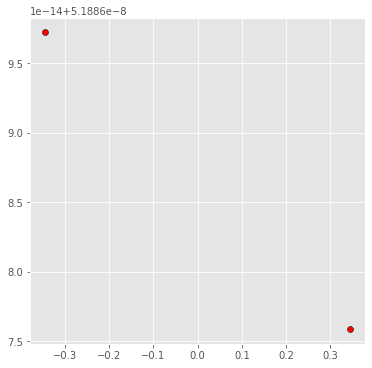

In [106]:
%matplotlib inline
display_pca_scatterplot(embedding1, embedding2)

Pretty far for very reasonably similar sentences. Maybe the scale on both axes of the graphs may differ. So this didn't help.

<br>

To calculate the similarity, researchers tried a lot of calculations on the embeddings. How would you determine if two points on a space is close? It's obvious. We find the distance between them.

In [107]:
# We have taken the magnitude of difference of the two embedding vectors - essentially calculating its distance,
# or more mathematically called 'Euclidean distance'.
dist = np.linalg.norm(embedding1 - embedding2)
dist

0.6877326

Initially, the researchers did find it exciting and applied it as a measure to find similar sentences, but it did not provide the accuracy we needed. We had to find the similarities **semantically.**

<br>

The next and by far the best method to calculate that, is _cosine similarity._

<br>

The cosine similarity determines the cosine of the angle between the two vectors. As said, this is a mathematical calculation done on a computer so even if you cannot visualize a 768-dimensional vector, you can still compute it.

In [108]:
cosine_sim = util.cos_sim(embedding1, embedding2)
print("Cosine-Similarity:", cosine_sim)


Cosine-Similarity: tensor([[0.7635]])


We have now seen how SentenceTransformer is used. Now, let us get inside and analyze how it works. Before that, it is important to know how this came to existence.

The initial approach to finding similar sentences using BERT was to use a cross-encoder. In this approach, we feed both sentences into BERT model and we use the [CLS] token of the result to calculate the similarity output. But this proved computationally very intensive.

<br>

SentenceBERT uses a siamese BERT architecture, meaning, we find encoder representations for each token in each sentence, do a pooling process to extract the sentence embedding, and apply cosine_sim to it. This is computationally less intensive and also showed good enough accuracy.

<br>

Let's tear it apart and sew it back up.

In [109]:
# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 'Each sentence is converted']
sentences

['This is an example sentence', 'Each sentence is converted']

In [110]:
# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

In [111]:
# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
encoded_input

{'input_ids': tensor([[ 101, 2023, 2003, 2019, 2742, 6251,  102],
        [ 101, 2169, 6251, 2003, 4991,  102,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0]])}

In [112]:
# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

model_output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.0366, -0.0162,  0.1682,  ...,  0.0554, -0.1644, -0.2967],
         [ 0.7239,  0.6399,  0.1888,  ...,  0.5946,  0.6206,  0.4897],
         [ 0.0064,  0.0203,  0.0448,  ...,  0.3464,  1.3170, -0.1670],
         ...,
         [ 0.1479, -0.0643,  0.1457,  ...,  0.8837, -0.3316,  0.2975],
         [ 0.5212,  0.6563,  0.5607,  ..., -0.0399,  0.0412, -1.4036],
         [ 1.0824,  0.7140,  0.3986,  ..., -0.2301,  0.3243, -1.0313]],

        [[ 0.2802,  0.1165, -0.0418,  ...,  0.2711, -0.1685, -0.2961],
         [ 0.8729,  0.4545, -0.1091,  ...,  0.1365,  0.4580, -0.2042],
         [ 0.4752,  0.5731,  0.6304,  ...,  0.6526,  0.5612, -1.3268],
         ...,
         [ 0.6113,  0.7920, -0.4685,  ...,  0.0854,  1.0592, -0.2983],
         [ 0.4115,  1.0946,  0.2385,  ...,  0.8984,  0.3684, -0.7333],
         [ 0.1374,  0.5555,  0.2678,  ...,  0.5426,  0.4665, -0.5284]]]), pooler_output=tensor([[ 1.3429e-02,  4.0036e-02,  3.

This is where the next layer of operations are done. We perform a pooling operation, where we take the vectors of each token and multiply it with its attention mask. We then divide the resulting vector by the sum of attention vectors to produce the final sentence embedding. (This method is called mean pooling - I wonder why)

In [113]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float() #Change dimensions of attention mask for multiplication with the matrix.
    return torch.sum(token_embeddings * input_mask_expanded, 1)/ torch.clamp(input_mask_expanded.sum(1), min=1e-9) # torch.clamp exists for a reason, think and tell me why. Don't Google.

In [114]:
# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

In [115]:
# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

In [116]:
print("Sentence embeddings:")
print(sentence_embeddings)

Sentence embeddings:
tensor([[ 6.7657e-02,  6.3496e-02,  4.8713e-02,  7.9305e-02,  3.7448e-02,
          2.6528e-03,  3.9375e-02, -7.0985e-03,  5.9361e-02,  3.1537e-02,
          6.0098e-02, -5.2905e-02,  4.0607e-02, -2.5931e-02,  2.9843e-02,
          1.1269e-03,  7.3515e-02, -5.0382e-02, -1.2239e-01,  2.3703e-02,
          2.9727e-02,  4.2477e-02,  2.5634e-02,  1.9952e-03, -5.6919e-02,
         -2.7160e-02, -3.2904e-02,  6.6025e-02,  1.1901e-01, -4.5879e-02,
         -7.2621e-02, -3.2584e-02,  5.2341e-02,  4.5055e-02,  8.2531e-03,
          3.6702e-02, -1.3942e-02,  6.5392e-02, -2.6427e-02,  2.0641e-04,
         -1.3664e-02, -3.6281e-02, -1.9504e-02, -2.8974e-02,  3.9427e-02,
         -8.8409e-02,  2.6243e-03,  1.3671e-02,  4.8306e-02, -3.1157e-02,
         -1.1733e-01, -5.1169e-02, -8.8529e-02, -2.1896e-02,  1.4299e-02,
          4.4417e-02, -1.3482e-02,  7.4339e-02,  2.6638e-02, -1.9876e-02,
          1.7919e-02, -1.0605e-02, -9.0426e-02,  2.1327e-02,  1.4120e-01,
         -6.4717e

In [117]:
cosine_scores = util.cos_sim(sentence_embeddings[0],sentence_embeddings[1])
cosine_scores

tensor([[0.4046]])

Here we can see what is an extension of sentence similarity. In a given set of sentences, we try to find the two most similar sentences and display it.

In [118]:
# Single list of sentences
sentences = ['The cat sits outside',
             'A man is playing guitar',
             'I love pasta',
             'The new movie is awesome',
             'The cat plays in the garden',
             'A woman watches TV',
             'The new movie is so great',
             'Do you like pizza?']

In [119]:
#Define the models
model = SentenceTransformer('all-MiniLM-L6-v2')

#Compute embeddings
embeddings = model.encode(sentences, convert_to_tensor=True)

#Compute cosine-similarities for each sentence with each other sentence
cosine_scores = util.cos_sim(embeddings, embeddings)

In [120]:
#Find the pairs with the highest cosine similarity scores
pairs = []
for i in range(len(cosine_scores)-1):
    for j in range(i+1, len(cosine_scores)):
        pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})

In [121]:
#Sort scores in decreasing order
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

df = pd.DataFrame(columns = ['Sentence_1','Sentence_2','Cosine_Sim'])
for pair in pairs[0:10]:
    i, j = pair['index']
    df = df.append({'Sentence_1':sentences[i],'Sentence_2':sentences[j], 'Cosine_Sim':pair['score']}, ignore_index = True)

df

,Sentence_1,Sentence_2,Cosine_Sim
0,The new movie is awesome,The new movie is so great,tensor(0.8939)
1,The cat sits outside,The cat plays in the garden,tensor(0.6788)
2,I love pasta,Do you like pizza?,tensor(0.5096)
3,I love pasta,The new movie is so great,tensor(0.2560)
4,I love pasta,The new movie is awesome,tensor(0.2440)
5,A man is playing guitar,The cat plays in the garden,tensor(0.2105)
6,The new movie is awesome,Do you like pizza?,tensor(0.1969)
7,The new movie is so great,Do you like pizza?,tensor(0.1692)
8,The cat sits outside,A woman watches TV,tensor(0.1310)
9,The cat plays in the garden,Do you like pizza?,tensor(0.0900)


I think this is pretty cool. Imagine, if we are given a huge corpus with billions of documents with such free text. If someone gives a query, we can try to find the most similar web document related to the query.

Lo and behold, we just came up with Google, dingus.

Execute the cell below to see it in action. (Here instead of documents, we use a list of sentences for your understanding).

In [122]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Corpus with example sentences
corpus = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'The girl is carrying a baby.',
          'A man is riding a horse.',
          'A woman is playing violin.',
          'Two men pushed carts through the woods.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'A cheetah is running behind its prey.'
          ]
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

# Query sentences:
queries = ['A man is eating pasta.', 'Someone in a gorilla costume is playing a set of drums.', 'A cheetah chases prey on across a field.']


# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = min(5, len(corpus))
for query in queries:
    query_embedding = embedder.encode(query, convert_to_tensor=True)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")

    for score, idx in zip(top_results[0], top_results[1]):
        print(corpus[idx], "(Score: {:.4f})".format(score))

# [FUN FACT] : Since 2020, almost every single English language query you enter
# in Google is powered by BERT. I told you. It's everywhere.





Query: A man is eating pasta.

Top 5 most similar sentences in corpus:
A man is eating food. (Score: 0.7035)
A man is eating a piece of bread. (Score: 0.5272)
A man is riding a horse. (Score: 0.1889)
A man is riding a white horse on an enclosed ground. (Score: 0.1047)
A cheetah is running behind its prey. (Score: 0.0980)




Query: Someone in a gorilla costume is playing a set of drums.

Top 5 most similar sentences in corpus:
A monkey is playing drums. (Score: 0.6433)
A woman is playing violin. (Score: 0.2564)
A man is riding a horse. (Score: 0.1389)
A man is riding a white horse on an enclosed ground. (Score: 0.1191)
A cheetah is running behind its prey. (Score: 0.1080)




Query: A cheetah chases prey on across a field.

Top 5 most similar sentences in corpus:
A cheetah is running behind its prey. (Score: 0.8253)
A man is eating food. (Score: 0.1399)
A monkey is playing drums. (Score: 0.1292)
A man is riding a white horse on an enclosed ground. (Score: 0.1097)
A man is riding a 

There we have it, the end of sentence similarity. And maybe the secret to powering a global conglomerate.